# Step #1 Download the Price Data via an API

In [6]:
# A tutorial for this file is available at www.relataly.com

from cryptocmd import CmcScraper
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn import cluster, covariance, manifold

# This list defines the coins that will be considered
symbol_dict = {
    'BTC': 'Bitcoin',
}

# Download historic crypto prices via CmcScraper
def load_fresh_data_and_save_to_disc(symbol_dict, save_path):
    # Initialize Coin Symbols List
    symbols, names = np.array(sorted(symbol_dict.items())).T
    for symbol in symbols:

        # Initialise scraper without time interval
        scraper = CmcScraper(symbol)

        # Pandas dataFrame for the same data
        df_coin_prices = scraper.get_dataframe()
        df = pd.DataFrame()
        print(f'fetching prices for {symbol}')
        df[symbol + '_Open'] = df_coin_prices['Open']
        df[symbol + '_Close'] = df_coin_prices['Close']
        df[symbol + '_Avg'] = (df_coin_prices['Close'] + df_coin_prices['Open']) / 2
            
    df.to_csv(save_path + 'historical_crypto_prices.csv')
    return names, symbols, df
        

# If set to False the data will only be downloaded when you execute the code
# Set to True, if you want a fresh copy of the data.  
fetch_new_data = False 
save_path = '' # path where the price data will be stored in a csv file

# Fetch fresh data via the scraping package, or use data from the csv file on disk
if fetch_new_data != fetch_new_data:
    try:
        print('loading from disk')
        df = pd.read_csv(save_path + 'historical_crypto_prices_btc.csv')
        if 'Unnamed: 0' in df.columns: 
            df = df.drop(['Unnamed: 0'], axis=1)
            symbols, names = np.array(sorted(symbol_dict.items())).T
        print(list(df.columns))
    except:
        print('no existing price data found - loading fresh data from coinmarketcap and saving them to disk')
        names, symbols, df = load_fresh_data_and_save_to_disc(symbol_dict, save_path)
else:
       print('loading fresh data from coinmarketcap and saving them to disk')
       names, symbols, df = load_fresh_data_and_save_to_disc(symbol_dict, save_path)


# Limit the price data to the last t days
df

loading fresh data from coinmarketcap and saving them to disk
fetching prices for BTC


,BTC_Open,BTC_Close,BTC_Avg
0,30273.654219,31022.905412,30648.279816
1,34060.015482,30296.953400,32178.484441
2,35502.940204,34059.264251,34781.102227
3,36042.503694,35501.954144,35772.228919
4,36573.182355,36040.922350,36307.052353
...,...,...,...
3295,116.379997,105.209999,110.794998
3296,139.000000,116.989998,127.994999
3297,144.000000,139.000000,141.500000
3298,134.444000,144.539993,139.491997


In [4]:
# # A tutorial for this file is available at www.relataly.com

# from Historic_Crypto import HistoricalData
# import pandas as pd 
# from scipy.stats import pearsonr
# import matplotlib.pyplot as plt 
# import matplotlib.colors as col 
# import numpy as np 
# import datetime

# # the price frequency in seconds: 21600 = 6 hour price data, 86400 = daily price data
# frequency = 21600

# # The beginning of the period for which prices will be retrieved
# from_date = '2017-01-01-00-00'
# # The currency price pairs for which the data will be retrieved
# coinlist = ['ETH-USD', 'BTC-USD']


# # Query the data
# for i in range(len(coinlist)):
#     coinname = coinlist[i]
#     pricedata = HistoricalData(coinname, frequency, from_date).retrieve_data()
#     pricedf = pricedata[['close', 'low', 'high']]
#     if i == 0:
#         df = pd.DataFrame(pricedf.copy())
#     else:
#         df = pd.merge(left=df, right=pricedf, how='left', left_index=True, right_index=True)   
#     df.rename(columns={"close": "close-" + coinname}, inplace=True)
#     df.rename(columns={"low": "low-" + coinname}, inplace=True)
#     df.rename(columns={"high": "high-" + coinname}, inplace=True)
# df.head()

Text(0.02, 0.95, 'BTC')

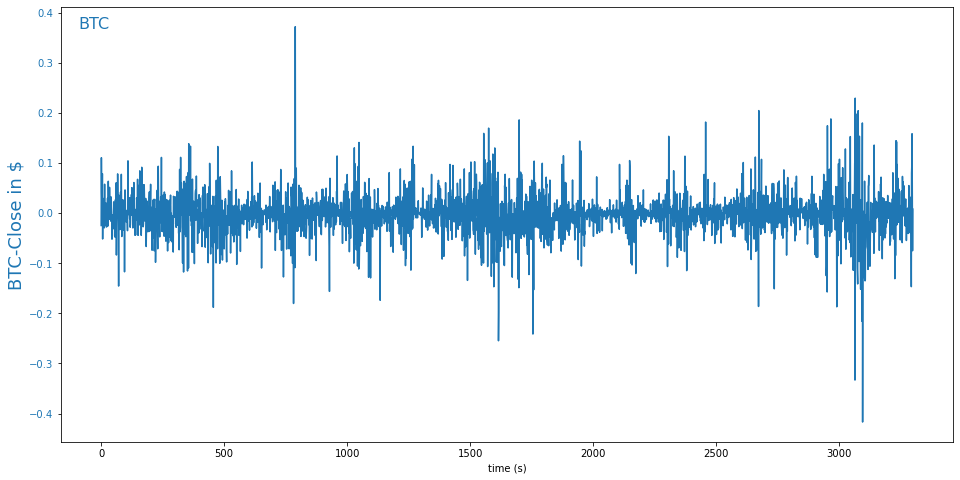

In [8]:
# Create a Price Chart on BTC and ETH
x = df.index
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=False)

# Price Chart for BTC-USD Close
color = 'tab:blue'
y = df['BTC_p']
ax1.set_xlabel('time (s)')
ax1.set_ylabel('BTC-Close in $', color=color, fontsize=18)
ax1.plot(x, y, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.text(0.02, 0.95, 'BTC',  transform=ax1.transAxes, color=color, fontsize=16)


# Step #2 Calculate Indicator Values

In [3]:
def add_indicators(df):
    # Calculate the 30 day Pearson Correlation 
    cor_period = 30 * dailyfreq #this corresponds to a monthly correlation period
    columntobeadded = [0] * cor_period
    df = df.fillna(0) 
    for i in range(len(df)-cor_period):
        btc = df['close-BTC-USD'][i:i+cor_period]
        eth = df['close-ETH-USD'][i:i+cor_period]
        corr, _ = pearsonr(btc, eth)
        columntobeadded.append(corr)    
    # insert the colours into our original dataframe    
    df.insert(2, "P_Correlation", columntobeadded, True)

    # Calculate the RSI
    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['low-BTC-USD'].rolling(window=200*dailyfreq).min()
    df['MA14_low'] = df['low-BTC-USD'].rolling(window=14*dailyfreq).min()
    df['MA200_high'] = df['high-BTC-USD'].rolling(window=200*dailyfreq).max()
    df['MA14_high'] = df['high-BTC-USD'].rolling(window=14*dailyfreq).max()

    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['close-BTC-USD'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Replace nas 
    #nareplace = df.at[df.index.max(), 'close-BTC-USD']    
    df.fillna(0, inplace=True)    
    return df

dailyfreq = int(86400/frequency) #because we do not use daily price points, we need to multiply the periods
dfcr = add_indicators(df)

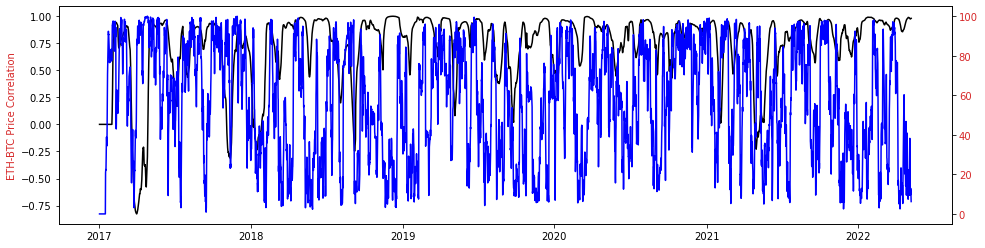

In [4]:
# Visualize measures
fig, ax1 = plt.subplots(figsize=(16, 4), sharex=False)
plt.ylabel('ETH-BTC Price Correlation', color=color)  # we already handled the x-label with ax1
x = y = dfcr.index
ax1.plot(x, dfcr['P_Correlation'], color='black')
ax2 = ax1.twinx()
ax2.plot(x, dfcr['RSI'], color='blue')
plt.tick_params(axis='y', labelcolor=color)

plt.show()

# Step #3 Color Code Indicator Values

In [5]:
# function that converts a given set of indicator values to colors
def get_colors(ind, colormap):
    colorlist = []
    norm = col.Normalize(vmin=ind.min(), vmax=ind.max())
    for i in ind:
        colorlist.append(list(colormap(norm(i))))
    return colorlist

# convert the RSI                         
y = np.array(dfcr['RSI'])
colormap = plt.get_cmap('plasma')
dfcr['rsi_colors'] = get_colors(y, colormap)

# convert the Pearson Correlation
y = np.array(dfcr['P_Correlation'])
colormap = plt.get_cmap('Spectral')
dfcr['cor_colors'] = get_colors(y, colormap)

# Step #4 Create a Bitcoin Price Chart Colored by RSI

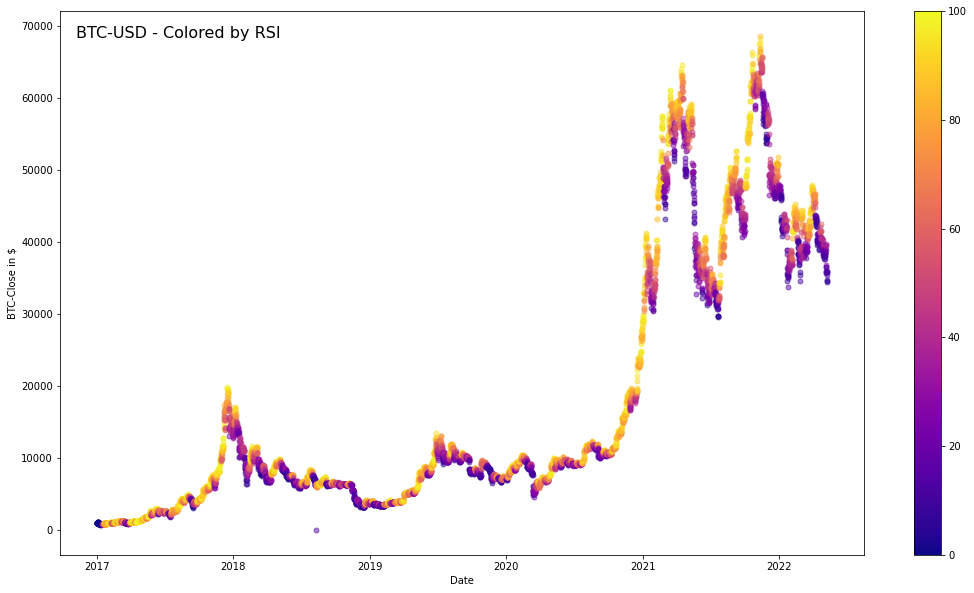

In [6]:
# setup the data for the price chart
pd.plotting.register_matplotlib_converters()
fig, ax1 = plt.subplots(figsize=(18, 10), sharex=False)
x = dfcr.index
y = dfcr['close-BTC-USD']
z = dfcr['rsi_colors']

# draw points
for i in range(len(dfcr)):
    ax1.plot(x[i], np.array(y[i]), 'o',  color=z[i], alpha = 0.5, markersize=5)
ax1.set_ylabel('BTC-Close in $')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlabel('Date')
ax1.text(0.02, 0.95, 'BTC-USD - Colored by RSI',  transform=ax1.transAxes, fontsize=16)

# plot the color bar
pos_neg_clipped = ax2.imshow(list(z), cmap='plasma', vmin=0, vmax=100, interpolation='none')
cb = plt.colorbar(pos_neg_clipped)

# Step #5 Create a Bitcoin Price Chart colored by Correlation Coefficient BTC-ETH

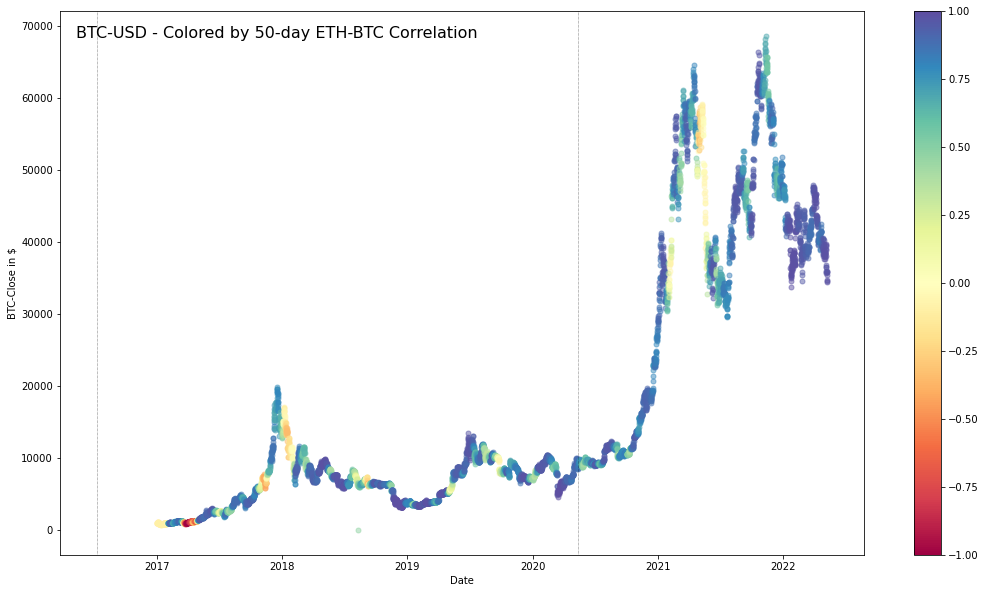

In [7]:


# setup the data for the price chart
pd.plotting.register_matplotlib_converters()
fig, ax1 = plt.subplots(figsize=(18, 10), sharex=False)
x = dfcr.index # datetime index
y = dfcr['close-BTC-USD'] # the price variable
z = dfcr['cor_colors'] # the color coded indicator values

# draw points
for i in range(len(dfcr)):
    ax1.plot(x[i], np.array(y[i]), 'o',  color=z[i], alpha = 0.5, markersize=5)
ax1.set_ylabel('BTC-Close in $')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlabel('Date')
ax1.text(0.02, 0.95, 'BTC-USD - Colored by 50-day ETH-BTC Correlation',  transform=ax1.transAxes, fontsize=16)

# plot the color bar
pos_neg_clipped = ax2.imshow(list(z), cmap='Spectral', vmin=-1, vmax=1, interpolation='none')
cb = plt.colorbar(pos_neg_clipped)


# add bitcoin halving dates asvertical lines
halving_dates = [[2016, 7, 9], [2020, 5, 11]] # past halvings [2009, 1, 3],[2009, 1, 3], [2012, 11, 28] upcoming halving [2024, 6, 1], [2028, 6, 1]
for i in range(0, len(halving_dates)):
    date_i = halving_dates[i]
    plt.axvline(x=[datetime.date(date_i[0], date_i[1], date_i[2])], color = 'black', linewidth=0.5, linestyle='dotted')